In [ ]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 2: Define file paths
# This is the path to the zip file you just uploaded
zip_file_path = "/content/drive/MyDrive/MusicClassifier/Data/archive.zip"

# This is the path to the folder where you want to extract the contents
# We want to extract them INSIDE the 'Data' folder
destination_path = "/content/drive/MyDrive/MusicClassifier/Data/"

In [ ]:
# Cell 3: Unzip the file
!unzip -q "{zip_file_path}" -d "{destination_path}"

print("File unzipped successfully!")

replace /content/drive/MyDrive/MusicClassifier/Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
File unzipped successfully!


# New Section

In [ ]:
# Cell 2: Install Librosa, Define Paths, and Imports
!pip install librosa

import os
import json
import librosa
import numpy as np

# --- DEFINE YOUR PATHS ---
# Make sure this points to your 'genres_original' folder on Google Drive
DATASET_PATH = "/content/drive/MyDrive/MusicClassifier/Data/genres_original"
# This is where the processed data will be saved
JSON_PATH = "/content/drive/MyDrive/MusicClassifier/data.json"

# Preprocessing parameters
SAMPLE_RATE = 22050
DURATION = 30  # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
NUM_SEGMENTS = 10
SAMPLES_PER_SEGMENT = int(SAMPLES_PER_TRACK / NUM_SEGMENTS)

# MFCC extraction parameters
N_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
NUM_MFCC_VECTORS_PER_SEGMENT = int(np.ceil(SAMPLES_PER_SEGMENT / HOP_LENGTH))

In [ ]:
# Cell 3: MFCC Extraction Function

def save_mfcc(dataset_path, json_path, n_mfcc, n_fft, hop_length, num_segments):
    """
    Extracts MFCCs from all audio files and saves them to a JSON file.
    """
    data = {
        "mapping": [],  # Genre labels (e.g., "blues", "classical")
        "mfcc": [],     # The extracted MFCC features
        "labels": []    # The corresponding integer label
    }

    print("Processing audio files...")

    # Loop through all genre folders
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # Ensure we're not at the root level
        if dirpath is not dataset_path:

            # Save the genre label
            genre_name = os.path.basename(dirpath)
            data["mapping"].append(genre_name)
            print(f"\nProcessing genre: {genre_name}")

            # Loop through all audio files in the genre folder
            for f in filenames:
                if f.endswith(".wav"):
                    file_path = os.path.join(dirpath, f)

                    try:
                        # Load audio file
                        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

                        # Process segments
                        for s in range(num_segments):
                            start_sample = SAMPLES_PER_SEGMENT * s
                            end_sample = start_sample + SAMPLES_PER_SEGMENT

                            # Extract MFCCs
                            mfcc = librosa.feature.mfcc(
                                y=signal[start_sample:end_sample],
                                sr=sr,
                                n_mfcc=n_mfcc,
                                n_fft=n_fft,
                                hop_length=hop_length
                            )
                            mfcc = mfcc.T

                            # Ensure MFCCs have the expected shape
                            if mfcc.shape[0] == NUM_MFCC_VECTORS_PER_SEGMENT:
                                data["mfcc"].append(mfcc.tolist())
                                data["labels"].append(i - 1) # Use i-1 because i starts at 1
                                print(f".", end="")
                            else:
                                print(f"x", end="") # Skip if shape is wrong

                    except Exception as e:
                        print(f"\nError processing {file_path}: {e}")

    print("\n\nFinished processing.")

    # Save to JSON file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
    print(f"Data saved to {json_path}")

In [ ]:
# Cell 4: Run the Preprocessing
# This will take a few minutes. Grab a coffee!
# It will print dots '.' for successful segments and 'x' for failed ones.

# Only run this if the data.json file doesn't exist yet!
if not os.path.exists(JSON_PATH):
    save_mfcc(DATASET_PATH, JSON_PATH, N_MFCC, N_FFT, HOP_LENGTH, NUM_SEGMENTS)
else:
    print(f"Data file already exists at {JSON_PATH}. Skipping preprocessing.")

Data file already exists at /content/drive/MyDrive/MusicClassifier/data.json. Skipping preprocessing.


In [ ]:
# Cell 5: Load Libraries and Data
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Path to your JSON file on Google Drive
DATA_PATH = "/content/drive/MyDrive/MusicClassifier/data.json"

def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    # Convert lists to numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y

# Load the data
X, y = load_data(DATA_PATH)

In [ ]:
# Cell 6: Prepare Data (Train/Test Split)

# Create the train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Get the input shape for the CNN
INPUT_SHAPE = (X_train.shape[1], X_train.shape[2], 1) # (130, 13, 1)

# Add the channel dimension to the MFCC data
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print(f"Input shape: {INPUT_SHAPE}")
print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")

Input shape: (130, 13, 1)
Train data shape: (7988, 130, 13, 1)
Test data shape: (1998, 130, 13, 1)


In [ ]:
# Cell 7: Build the CNN Model

def build_model(input_shape):
    model = models.Sequential()

    # Layer 1: Conv -> ReLU -> MaxPool
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    # Layer 2: Conv -> ReLU -> MaxPool
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    # Layer 3: Conv -> ReLU -> MaxPool
    model.add(layers.Conv2D(128, (2, 2), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())

    # Flatten the output and feed into Dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))

    # Output layer (10 genres)
    model.add(layers.Dense(10, activation='softmax'))

    return model

model = build_model(INPUT_SHAPE)
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 31, 2, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 1, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 1, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1920)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 578,570 (2.21 MB)

 Trainable params: 578,122 (2.21 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
# Cell 8: Train the Model
# With a T4 GPU, this should be much faster!

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=100,  # Feel free to train for more epochs
                    batch_size=32)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 30ms/step - accuracy: 0.2688 - loss: 2.2854 - val_accuracy: 0.5345 - val_loss: 1.3824
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4630 - loss: 1.5206 - val_accuracy: 0.5931 - val_loss: 1.1508
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5407 - loss: 1.2932 - val_accuracy: 0.6381 - val_loss: 1.0330
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5855 - loss: 1.1730 - val_accuracy: 0.6612 - val_loss: 0.9616
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6343 - loss: 1.0512 - val_accuracy: 0.6862 - val_loss: 0.9087
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6681 - loss: 0.9342 - val_accuracy: 0.6927 - val_loss: 0.8812
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7106 - loss: 0.8324 - val_accuracy: 0.7187 - val_loss: 0.8235
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7247 - loss: 0.8022 - val_ac

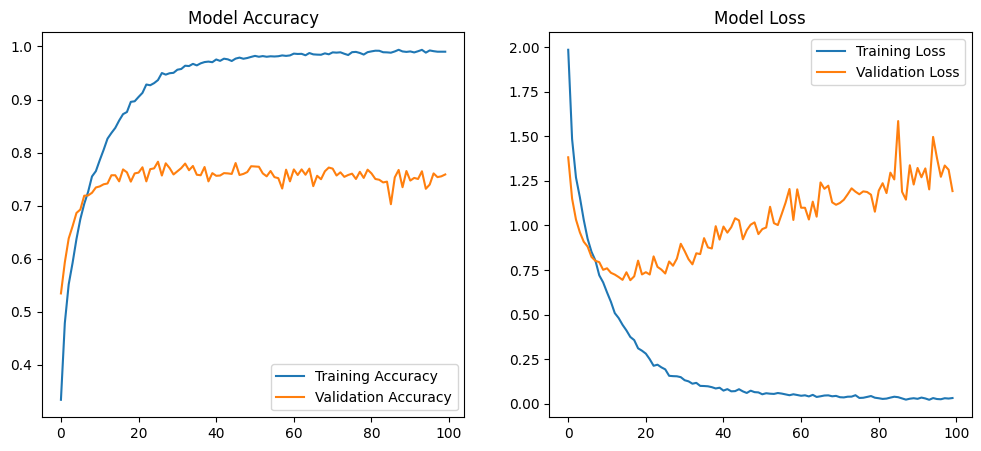

63/63 - 0s - 3ms/step - accuracy: 0.7588 - loss: 1.1928



Test accuracy: 75.88%
Model saved to /content/drive/MyDrive/MusicClassifier/genre_classifier.h5


In [ ]:
# Cell 9: Evaluate and Save the Model

# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc*100:.2f}%')

# --- SAVE THE MODEL TO YOUR GOOGLE DRIVE ---
MODEL_SAVE_PATH = "/content/drive/MyDrive/MusicClassifier/genre_classifier.h5"
model.save(MODEL_SAVE_PATH)
print(f"Model saved to {MODEL_SAVE_PATH}")

In [ ]:
# Cell 10: Prediction Setup (Load Model and Define Functions)

import librosa
import numpy as np
import tensorflow as tf
import json
import matplotlib.pyplot as plt
import librosa.display
from google.colab import files # For uploading files

# --- LOAD MODEL AND MAPPINGS FROM DRIVE ---
MODEL_PATH = "/content/drive/MyDrive/MusicClassifier/genre_classifier.h5"
JSON_PATH = "/content/drive/MyDrive/MusicClassifier/data.json"

model = tf.keras.models.load_model(MODEL_PATH)

with open(JSON_PATH, "r") as fp:
    data = json.load(fp)
GENRE_MAPPINGS = data["mapping"]

# Re-define constants (must be identical to training)
SAMPLE_RATE = 22050
N_MFCC = 13
N_FFT = 2048
HOP_LENGTH = 512
SAMPLES_PER_SEGMENT = int((SAMPLE_RATE * 30) / 10)
NUM_MFCC_VECTORS_PER_SEGMENT = int(np.ceil(SAMPLES_PER_SEGMENT / HOP_LENGTH))


def visualize_spectrogram(signal, sr, file_path):
    """
    Generates and saves a Mel Spectrogram (Optional).
    """
    S = librosa.feature.melspectrogram(y=signal, sr=sr, n_mels=128)
    S_db = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram - {os.path.basename(file_path)}')
    plt.tight_layout()
    plt.savefig("spectrogram.png") # Saves to Colab session
    plt.show()

    print(f"Spectrogram saved to spectrogram.png")


def predict_genre(audio_file_path):
    """
    Predicts the genre of a single audio file. (Corrected Version)
    """
    try:
        # 1. Load audio file
        signal, sr = librosa.load(audio_file_path, sr=SAMPLE_RATE)

        # 2. Visualize Spectrogram (Optional)
        # We'll move this call to after the check, in case the file is too short

        # 3. Process in segments
        predictions = []
        total_segments = int(np.ceil(len(signal) / SAMPLES_PER_SEGMENT))

        if total_segments < 1:
            print("Error: Audio file is too short to process.")
            return

        # Only show spectrogram if file is long enough
        visualize_spectrogram(signal, sr, audio_file_path)

        for s in range(total_segments):
            start_sample = SAMPLES_PER_SEGMENT * s
            end_sample = start_sample + SAMPLES_PER_SEGMENT
            segment = signal[start_sample:end_sample]

            # ---------------------
            # --- FIX IS HERE ---
            # ---------------------
            # Check if the segment is shorter than the FFT window size
            if len(segment) < N_FFT:
                # This segment is too short for analysis, skip it.
                print(f"\nSkipping segment {s+1}: Audio segment is too short ({len(segment)} samples) for analysis (n_fft={N_FFT}).")
                continue # Skip to the next segment
            # ---------------------
            # --- END OF FIX ---
            # ---------------------

            # 4. Extract MFCCs
            mfcc = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=N_MFCC, n_fft=N_FFT, hop_length=HOP_LENGTH)
            mfcc = mfcc.T

            # 5. Check shape and pad if necessary
            if mfcc.shape[0] < NUM_MFCC_VECTORS_PER_SEGMENT:
                pad_width = NUM_MFCC_VECTORS_PER_SEGMENT - mfcc.shape[0]
                mfcc = np.pad(mfcc, ((0, pad_width), (0, 0)), mode='constant')

            if mfcc.shape[0] == NUM_MFCC_VECTORS_PER_SEGMENT:
                mfcc_reshaped = mfcc[np.newaxis, ..., np.newaxis]

                # 6. Get prediction
                prob_distribution = model.predict(mfcc_reshaped, verbose=0)[0]
                predictions.append(prob_distribution)

        if not predictions:
            print("Could not extract any valid segments. The audio file might be too short.")
            return

        # 7. Average predictions across all segments
        avg_prediction = np.mean(predictions, axis=0)

        # 8. Get final genre and confidence
        predicted_index = np.argmax(avg_prediction)
        predicted_genre = GENRE_MAPPINGS[predicted_index]
        confidence = avg_prediction[predicted_index]

        print(f"\n--- Prediction ---")
        print(f"File: {os.path.basename(audio_file_path)}")
        print(f"Predicted Genre: {predicted_genre.upper()}")
        print(f"Confidence Score: {confidence * 100:.2f}%")
        print("--------------------")

    except Exception as e:
        print(f"Error during prediction: {e}")

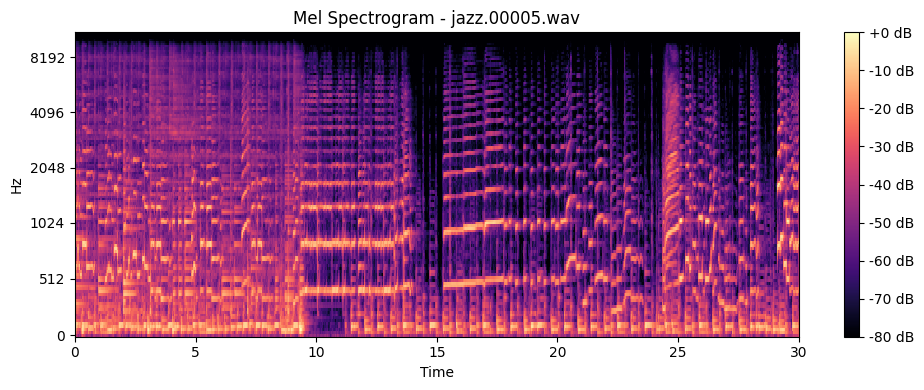

Spectrogram saved to spectrogram.png

Skipping segment 11: Audio segment is too short (294 samples) for analysis (n_fft=2048).

--- Prediction ---
File: jazz.00005.wav
Predicted Genre: JAZZ
Confidence Score: 99.99%
--------------------


--- OR ---
Upload your own audio file (.wav, .mp3) to classify:


Saving Kaise Hua – Vishal Mishra _ Kabir Singh Ringtone Download - MobCup.Com.Co.mp3 to Kaise Hua – Vishal Mishra _ Kabir Singh Ringtone Download - MobCup.Com.Co (1).mp3

User uploaded file: Kaise Hua – Vishal Mishra _ Kabir Singh Ringtone Download - MobCup.Com.Co (1).mp3


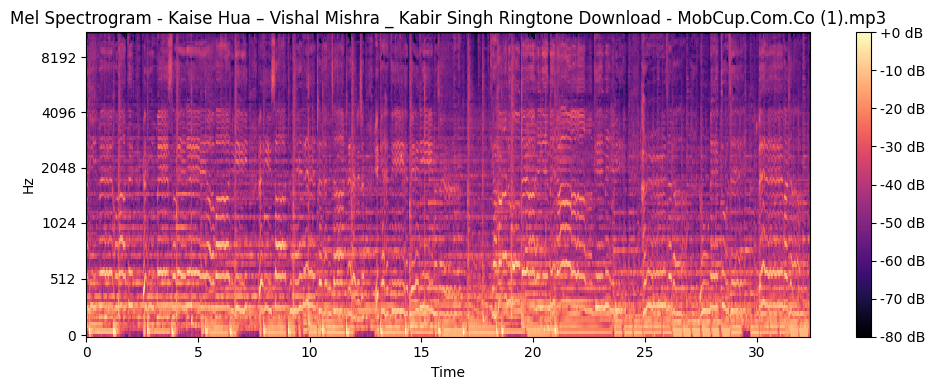

Spectrogram saved to spectrogram.png

--- Prediction ---
File: Kaise Hua – Vishal Mishra _ Kabir Singh Ringtone Download - MobCup.Com.Co (1).mp3
Predicted Genre: COUNTRY
Confidence Score: 62.79%
--------------------


In [ ]:
# Cell 11: Run the Demo!

# --- Option 1: Test with a file from your dataset ---
TEST_FILE_FROM_DRIVE = "/content/drive/MyDrive/MusicClassifier/Data/genres_original/jazz/jazz.00005.wav"
if os.path.exists(TEST_FILE_FROM_DRIVE):
    predict_genre(TEST_FILE_FROM_DRIVE)
else:
    print(f"Test file not found at: {TEST_FILE_FROM_DRIVE}")


# --- Option 2: Upload your own audio file ---
print("\n\n--- OR ---")
print("Upload your own audio file (.wav, .mp3) to classify:")

try:
    # This will open an upload dialog in Colab
    uploaded = files.upload()

    # Get the name of the file you just uploaded
    for file_name in uploaded.keys():
        print(f"\nUser uploaded file: {file_name}")
        # The file is now in the Colab session storage
        predict_genre(file_name)

except Exception as e:
    print(f"Upload failed or was cancelled. {e}")